In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

Using Theano backend.
Using gpu device 0: GeForce GTX 660 (CNMeM is disabled, cuDNN 4007)


In [4]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
nb_epoch = 50

In [5]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [6]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=30,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 3s - loss: 153.3443 - val_loss: 154.1785
Epoch 2/30
60000/60000 [==============================] - 3s - loss: 153.1541 - val_loss: 154.0992
Epoch 3/30
60000/60000 [==============================] - 3s - loss: 152.9157 - val_loss: 153.8759
Epoch 4/30
60000/60000 [==============================] - 3s - loss: 152.7032 - val_loss: 153.8865
Epoch 5/30
60000/60000 [==============================] - 3s - loss: 152.5374 - val_loss: 153.4515
Epoch 6/30
60000/60000 [==============================] - 3s - loss: 152.3535 - val_loss: 153.4293
Epoch 7/30
60000/60000 [==============================] - 3s - loss: 152.1552 - val_loss: 153.1745
Epoch 8/30
60000/60000 [==============================] - 3s - loss: 151.9748 - val_loss: 153.2095
Epoch 9/30
20000/60000 [=========>....................] - ETA: 2s - loss: 151.5567

In [14]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

Start predicting
Start plotting


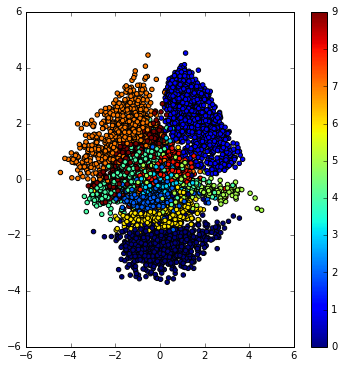

In [15]:
# display a 2D plot of the digit classes in the latent space
print "Start predicting"
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
print "Start plotting"
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

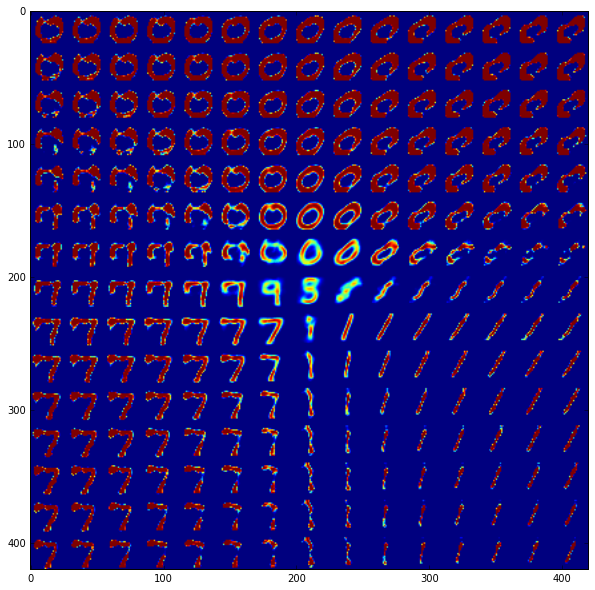

In [16]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()